In [1]:
#Inspired by and adapted to my needs from https://github.com/ageron
#Based on Mnih 2013, playing atari with deep reinforcement learning

In [2]:
%reset -f
import tensorflow as tf
from importlib import reload
sess = tf.InteractiveSession()
import os
import random
from params import * 
import world 
from copy import copy
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
%matplotlib inline

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
world = reload(world)
my_world = world.world(game_mode='abs_length')

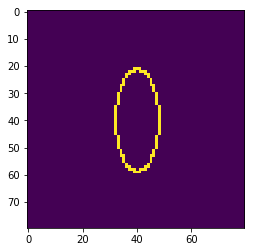

In [4]:
plt.imshow(my_world.get_frame()[:,:,0])


In [5]:
#New way of changing the axes: Change them by a certain percentage. 
#This is because the goal is to make the network indifferent to the scale of the ellipse and
#only learn to recognize the ratio that the axes have. However, if the benefit that an action has depends on the 
#scale, then learning to ignore the scale might prove difficult.

# Maybe need to change to different world, learning scale invariance might be an unnecessary complicated task
# requiring a network with too many parameters.

def increase_height():
    #change in percent
    my_world.change_height(.1)
def decrease_height():
    #change in percent
    my_world.change_height(-.1)
def increase_width():
    #change in percent
    my_world.change_width(.1)
def decrease_width():
    #change in percent
    my_world.change_width(-.1)
actions = [increase_height,decrease_height,increase_width,decrease_width]

num_actions = len(actions)

### How does the model architecture look like?

- We have the input with dimensions [FRAME_DIM,FRAME_DIM,1] (in the DQN of Mnih, the 4 last images are taken. However, our task is much simpler and does not require to learn any correlations between the images, so 1 is sufficient as the last dimension (taking just 1 image.)
- Moreover, in our case, it is sufficient to take $\Phi$ to be the identity function, since we do not need preprocessing for image cropping etc.


- First hidden layer: 16 filters of size 8x8 with stride 4. acitvation : relu
- Second hidden layer: 32 filters of size 4x4 with stride 2, again relu
- Final hidden 128 relus, fully connected.
- output layer: fully connected, one output for each action. 

In [6]:
dqn_args   = {"n_out_h1" : 16, "kernel_size_h1":(8,8), "strides_h1" : 4, "padding" : "SAME", \
              "actvt_fct" : tf.nn.relu, "n_out_h2" : 32, "kernel_size_h2":(4,4), "strides_h2" : 2, \
              "n_out_h3" : 128,"initializer" : tf.contrib.layers.variance_scaling_initializer() }

learning_rate  = 10**(-3)

# start training after memory is somewhat filled.
training_start = 500  
# gamma discount factor for future rewards. 
discount_rate  = 0.8 
batch_size     = 32 

#Precision at what the goal state will be accepted. For more info look at my_world.game_over()
precision = 2


over = True

# We will keep track of the max Q-Value over time and compute the mean per game
prediction_loss = np.infty
game_length = 0
finished   = -1



num_total_updates = 50000
verbose = True

#Time interval after which the target network gets updated by the online learning network
learn_period = 20


game_length_over_t = []

time = []
t = 0 

#Epsilon greedy policy: initially fully exploratory then decaying epsilon
eps_min = 0.25
eps_max = 1.0 
exploratory_steps = num_total_updates//6
eps_decay_steps = num_total_updates-exploratory_steps

In [7]:
def network(name, n_out_h1=None, kernel_size_h1 = None, strides_h1 = None, padding = None,\
            actvt_fct = None, n_out_h2 = None, kernel_size_h2 = None, strides_h2 = None,\
           n_out_h3 = None, initializer = None):
    
    '''Creates a network with its variables in the scope network/{name}.
       Useful for creating an online learning network and a network for target prediction.
       Returns the nodes of the network and their names within their scope. These names can
       be used for easily transferring the variable values from the online network to the predicting network.
    '''    
    
    with tf.variable_scope("network/"+name,reuse=tf.AUTO_REUSE) as scope:
        
        ### First two layers are convolutional layers.
        h_1 = tf.layers.conv2d(x, filters = n_out_h1, kernel_size = kernel_size_h1, strides = strides_h1,\
                               padding = padding, activation = actvt_fct, kernel_initializer = initializer)
        h_2 = tf.layers.conv2d(x, filters = n_out_h2, kernel_size = kernel_size_h2, strides = strides_h2,\
                               padding = padding, activation = actvt_fct, kernel_initializer = initializer)
        
        
        ### Third layer is a fully connected layer. Therefore pass the flattened h_2 into the network.
        h_3 = tf.layers.dense(tf.layers.Flatten()(h_2), n_out_h3, activation=actvt_fct,kernel_initializer=initializer)
        
        ### Finally the last fully connected layer. This will give the q-value estimate for each action respectively
        #   at the state that was passed into the first layer. No acitvation function needed.
        q_values = tf.layers.dense(h_3, num_actions,kernel_initializer=initializer)
        
        ### Collect all the variables that are defined within this scope.
        theta    = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=scope.name)
        ### Get their names within their scope: This allows for using the names to pass from
        #   online to target by just using the relative names.
        theta_names = {var.name[len(scope.name):]: var for var in theta}
        
        return q_values, theta_names
        
        
        

In [8]:


#x is our current state, i.e. just the current image.
#Same for learning network as for predicting network, therefore defined outside the scope so that it can be shared.
x = tf.placeholder(tf.float32, shape=[None, FRAME_DIM,FRAME_DIM,1])

learner_out  , learner_vars   = network("learner"  ,**dqn_args)
predictor_out, predictor_vars = network("predictor",**dqn_args)

In [9]:
#clever way in tensorflow of updating the predictor network!
#Since all operations are just stored as nodes in the graph, the reassignment operations can be put into 
#a single group of operations. Whenever this group is then called during a session, the assignment node
# gets activated -> Transfer of current learning parameter values into the predicting network.
update_operations = [predictor_var.assign(learner_vars[var_name])
                    for var_name, predictor_var in predictor_vars.items()]

update_predictor = tf.group(*update_operations)


### Training step of the network

In [10]:
#Define all the variables that will be used for the training, e.g. actions taken, target, q_value and so on.

with tf.variable_scope("training",reuse=tf.AUTO_REUSE):
    
    #Placeholder for batch of actions during training.
    act_idx = tf.placeholder(tf.int32, shape=[None])
    #Placeholder for estimated discounted future reward achieved in a step.
    y = tf.placeholder(tf.float32, shape=[None, 1])
    
    # The q_value of the online learning network for a certain step.
    q_value = tf.reduce_sum(learner_out * tf.one_hot(act_idx, num_actions), axis=1, keep_dims=True)
    
    ### As in the paper by Mnih, loss is squared difference between target and estimate. 
    loss = tf.squared_difference(y,q_value,"loss")
    
    #Keeping track of how many batches the network has seen for training.
    global_step = tf.Variable(0, trainable=False, name='global_step')
    # Optimizer used by Mnih
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    training_step = optimizer.minimize(loss, global_step=global_step)

In [11]:
#Memory for replay
max_memory = 500
#Using deque so that max_length is automatically maintained when pushing new data into the replay buffer.
memory = deque([],maxlen=max_memory)


In [12]:
def sample_memories(batch_size):
    
    '''
    Sample memories from the replay buffer. Returns a batch of batch_size that includes the 
    remembered state-action-reward-next_state-game_over tuple.
    '''
    
    memo_batch  = np.array(random.sample(memory,batch_size))
    
    mem_states       = np.stack(np.array(memo_batch[:,0]))
    mem_actions      = np.stack(np.array(memo_batch[:,1]))
    mem_rewards      = np.stack(np.array(memo_batch[:,2]))
    mem_nxt_state    = np.stack(np.array(memo_batch[:,3]))
    mem_final_state  = np.stack(np.array(memo_batch[:,4]))

    
    return (mem_states, mem_actions, mem_rewards.reshape(-1, 1), mem_nxt_state, mem_final_state.reshape(-1, 1))


def epsilon_greedy(q_values, num_updates):
    '''
    Custom epsilon greedy policy. Learn completely random in the first "exploratory_steps" number of steps to
    explore the state space more or less equally. Then decay to minimal epsilon to become more and more greedy.
    '''
    
    #First completely random, then decaying linearly from eps_max to eps_min
    epsilon = 1 if num_updates< exploratory_steps else  \
                max(eps_min, eps_max - (eps_max-eps_min) * (num_updates-exploratory_steps)/eps_decay_steps)
        
    if np.random.rand() < epsilon:
        # explore
        return np.random.randint(num_actions) 
    else:
        # exploit
        return np.argmax(q_values) 



In [12]:
#!rm .index

In [13]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

start_at = 0
with tf.Session() as sess:
    
    if os.path.isfile("./.index"):
        saver.restore(sess, './')
        start_at = global_step.eval()
        #sess.run(tf.assign(global_step,0))
    else:
        init.run()
        
    #start with online being the same as predictor network
    update_predictor.run()
    
    print("Starting learning process - Filling memory.",end="")
    
    while True:
        t +=1
        num_updates = global_step.eval()
        if num_updates-start_at >= num_total_updates:
            saver.save(sess, "./")
            break
            
        #Reset world if goal is reached  
        if over:            
            finished +=1
            my_world.restart()
            state = my_world.get_frame()


        #Perform actions according to online network and our custom epsilon greedy policy.
        q_values = learner_out.eval(feed_dict={x: [state]})
        action_idx = epsilon_greedy(q_values, num_updates-start_at)
        #Perform action
        actions[action_idx]()
        #observe world...
        next_state, reward, over = (my_world.get_frame(),\
                                    my_world.get_reward(),\
                                    my_world.game_over(precision=precision))

        #Place observations in memory.
        memory.append((state, action_idx, reward, next_state, not over))

        
        state = next_state

        
        
        #Keep track of game_length over time
        game_length += 1

        if over:
            game_length_over_t.append(game_length)
            time.append(t)
            game_length = 0

        if len(memory) < training_start:
            
            #To entertain whomever is watching this..
            if len(memory) % training_start//5 == 0:
                print(".",end="")
            
            #skip first "training_start" steps until memory is filled enough
            continue
        
        
        #Print progress!
        elif verbose and num_updates % 100 == 0:
            print("\r Update {}/{} loss : {:.2f} "
                  " finished games:{} width {:.1f} height {:.1f} ratio {:.1f}".format(
             num_updates-start_at, num_total_updates,np.sum(prediction_loss)/batch_size,
             finished,my_world.haxis,my_world.vaxis,my_world.get_ratio()), end="")
            
            
        # Sample memories and use the target DQN to produce the target Q-Value
        mem_x, mem_action, mem_rewards, mem_next_state, continues = sample_memories(batch_size)
        
        #For target estimate use the predictor #bootstrappingFutureRewards..
        next_q_values = predictor_out.eval(feed_dict={x: mem_next_state})
        #Learn according to greedy policy.
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        
        #Target to achieve. 
        y_val = mem_rewards + continues * discount_rate * max_next_q_values

        #Perform training steps and calculate the loss
        _, prediction_loss = sess.run([training_step, loss], feed_dict={
            x: mem_x, act_idx: mem_action, y: y_val})

        # Update the predicting network every once in a while 
        if num_updates % learn_period == 0:
            update_predictor.run()

        # save tuned variables.
        if num_updates % 1000 == 0:
            saver.save(sess, "./")

 Update 49900/50000 loss : 0.21  finished games:1210 width 8.1 height 7.3 ratio 1.131

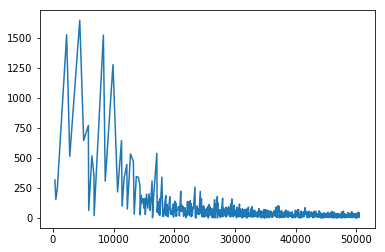

In [14]:
plt.plot(time, game_length_over_t)

In [18]:
game_length = 0
play_game_length_over_t = []
play_time = []
with tf.Session() as sess:
    
    if os.path.isfile("./.index"):
        saver.restore(sess, './')
        
        
        for t in range(2000):
            #Reset world if goal is reached  
            if over:            
                finished +=1
                my_world.restart()
                state = my_world.get_frame()


            #Perform actions according to online network and our custom epsilon greedy policy.
            q_values = predictor_out.eval(feed_dict={x: [state]})
            action_idx = np.argmax(q_values)
            #Perform action
            actions[action_idx]()
            #observe world...
            state, reward, over = (my_world.get_frame(),\
                                        my_world.get_reward(),\
                                        my_world.game_over(precision=precision))

           
            #Keep track of game_length over time
            game_length += 1

            if over:
                play_game_length_over_t.append(game_length)
                play_time.append(t)
                game_length = 0

INFO:tensorflow:Restoring parameters from ./
